# Mapas Covid

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.style as style
import os
import geopandas as gpd
import geoplot
import mapclassify
from tensorflow.keras.utils import get_file
from scipy import optimize
style.use('ggplot')

## Carregando dados
Utilizando planilha do [Portal sobre Covid19 do Ministério da Saúde]('https://covid.saude.gov.br/')

In [2]:
df = pd.read_excel('../data/HIST_PAINEL_COVIDBR_02jul2020.xlsx')
data_inicial_base = df['data'].min()

### delimitar data anterior

#data_final_base = pd.to_datetime('2020-06-23', format='%Y-%m-%d' )
#fltr = df['data'] <= data_final_base
#df = df.loc[fltr, :]

### 

print(df.shape)
data_final_base = df['data'].max()
print('dados do dia {} ao dia {}'.format(data_inicial_base, data_final_base))
# tratamento inicial dos valores de população
df['populacaoTCU2019'] = df['populacaoTCU2019'].fillna('0')
df['populacaoTCU2019'] = df['populacaoTCU2019'].str.split(pat='(', expand=True )
df['populacaoTCU2019'] = df['populacaoTCU2019'].str.replace('.','').astype(int)

(529284, 17)
dados do dia 2020-02-25 00:00:00 ao dia 2020-07-02 00:00:00


### Dias de semana como varíável categórica 

In [3]:
cat_dia_semana = pd.CategoricalDtype(categories=['dom', 'seg', 'ter', 'qua', 'qui', 'sex', 'sab'], ordered=True)
df['dia_semana'] = df['data'].dt.dayofweek
df['dia_semana_nm'] = df['dia_semana'].replace({0:'seg', 1: 'ter', 2:'qua', 3:'qui', 4:'sex', 5:'sab', 6:'dom'}).astype(cat_dia_semana)

In [4]:
uf_list= [ 'MS', 'AM']
Muni_list = ['Dourados', 'Manaus']


In [5]:
pathfigs = './figs/'

## Entre com as silgas dos estados e o nome das cidades para comparar

### Função de tratamento dos dados
* recebe o banco de dados, a sigla do estado e o nome da cidade
* retorna:
    1. DataFrame do estado
    1. DataFrame do estado agregado por semana epidemiológica
    1. DataFrame da cidade
    1. DataFrame da cidade agregado por semana epidemiológica


In [6]:
def preproc_comp_cidades(df1,estados, cidades):
    df1.sort_values('data', inplace = True)
    listDFs = []
    for i in range(len(estados)):
        # filtrando por estado
        fltr = df1['estado'].str.lower() == estados[i].lower()
        df_UF = df1.loc[fltr, :]
        # filtrando pro cidade
        fltr = df_UF['municipio'].str.lower() == cidades[i].lower()
        df_muni = df_UF.loc[fltr, :]

        ###
        #estado
        df_UF.dropna(subset=['municipio'])
        # esrado por município
        df_UF_muni = df_UF.groupby('municipio')
         # população do estado somatório dos municípios
        agg_estado = df_UF_muni.agg({'populacaoTCU2019': 'max', 'casosAcumulado': 'max'}).reset_index()
        popu_estado = agg_estado['populacaoTCU2019'].sum()
        casos_estado = agg_estado['casosAcumulado'].sum()
        
        df_UF_muni = df_UF_muni.agg({'populacaoTCU2019': 'max', 'casosAcumulado': 'max', 'obitosAcumulado': 'max',  }).reset_index()
        # estado por município, valores por 100 mil habitantes
        df_UF_muni['CA_por_cemMil_Hab'] = df_UF_muni['casosAcumulado'] * 10**5 / df_UF_muni['populacaoTCU2019']
        df_UF_muni['OA_por_cemMil_Hab'] = df_UF_muni['obitosAcumulado'] * 10**5 / df_UF_muni['populacaoTCU2019']
        df_UF_muni['CA_cemMil_log'] = df_UF_muni['CA_por_cemMil_Hab'].apply(lambda x: np.log10(x))
        df_UF_muni['OA_cemMil_log'] = df_UF_muni['OA_por_cemMil_Hab'].apply(lambda x: np.log10(x))

       
        print('População: somatório dos municípios do estado {} : {} '.format(estados[i], popu_estado))
        print('Casos: somatório dos municípios do estado {} : {} '.format(estados[i], casos_estado))
        print ('Casos por cem mil habintnates do estado {} : {} '.format(estados[i], casos_estado*10**5/popu_estado))

        # totalização dos casos do estado
        df_UF = df_UF.groupby('data')
        df_UF = df_UF.agg({'casosNovos': sum, 'obitosNovos': sum, 'casosAcumulado': sum, 'obitosAcumulado': sum,'populacaoTCU2019': 'max'}).reset_index()
        df_UF['CN_por_cemMil_Hab'] = df_UF['casosNovos'] * 10**5 / popu_estado
        df_UF['ON_por_cemMil_Hab'] = df_UF['obitosNovos'] * 10**5 / popu_estado
        df_UF['CA_por_cemMil_Hab'] = df_UF['casosAcumulado'] * 10**5 / popu_estado
        df_UF['OA_por_cemMil_Hab'] = df_UF['obitosAcumulado'] * 10**5 / popu_estado

        ## dias a partir da primeira notificação
        dia_0 = df_UF['data'].min()
        df_UF['dia_num'] = (df_UF['data'] - dia_0).apply(lambda x: x.days)
        
        ###
        #cidades

        print('população da cidade de {}: {}'.format(cidades[i], df_muni['populacaoTCU2019'].max() ))
        df_muni['CN_por_cemMil_Hab'] = df_muni['casosNovos'] * 10**5 / df_muni['populacaoTCU2019']
        df_muni['ON_por_cemMil_Hab'] = df_muni['obitosNovos'] * 10**5 / df_muni['populacaoTCU2019']
        df_muni['CA_por_cemMil_Hab'] = df_muni['casosAcumulado'] * 10**5 / df_muni['populacaoTCU2019']
        df_muni['OA_por_cemMil_Hab'] = df_muni['obitosAcumulado'] * 10**5 / df_muni['populacaoTCU2019']

        # escala logarítimica
        df_muni['CN_cemMil_log'] = df_muni['CN_por_cemMil_Hab'].apply(lambda x: np.log10(x))
        df_muni['ON_cemMil_log'] = df_muni['ON_por_cemMil_Hab'].apply(lambda x: np.log10(x))
        df_muni['CA_cemMil_log'] = df_muni['CA_por_cemMil_Hab'].apply(lambda x: np.log10(x))
        df_muni['OA_cemMil_log'] = df_muni['OA_por_cemMil_Hab'].apply(lambda x: np.log10(x))
        ## dias a partir da primeira notificação
        dia_0 = df_muni['data'].min()
        df_muni['dia_num'] = (df_muni['data'] - dia_0).apply(lambda x: x.days)

        #lista de saida
        listDFs.append(df_UF)
        listDFs.append(df_UF_muni)
        listDFs.append(df_muni)
           
    return listDFs

In [7]:
df_est1, df_est1_muni, df_cidade1, df_est2, df_est2_muni, df_cidade2 = preproc_comp_cidades(df, uf_list, Muni_list)

População: somatório dos municípios do estado MS : 2697867 
Casos: somatório dos municípios do estado MS : 9079 
Casos por cem mil habintnates do estado MS : 336.5251140993978 
população da cidade de Dourados: 222949
População: somatório dos municípios do estado AM : 4144597 
Casos: somatório dos municípios do estado AM : 73729 
Casos por cem mil habintnates do estado AM : 1778.9184328416009 
população da cidade de Manaus: 2182763


In [8]:

def comp_cidades(cidade1, cidade2, pathfigs = './figs/'):
    cidade1.sort_values('data', inplace = True)
    cidade2.sort_values('data', inplace = True)
    cidade1_nm = cidade1['municipio'].unique()[0]
    cidade2_nm = cidade2['municipio'].unique()[0]
    print(cidade1_nm, cidade2_nm)


    #delay dias
    fltr = cidade2['CA_por_cemMil_Hab'] > 0
    param1 = cidade2.loc[fltr,'CA_por_cemMil_Hab'].min()
    dia_0_ref = cidade2.loc[fltr,'data'].min()
    fltr = cidade1['CA_por_cemMil_Hab'] >= param1
    param2 = cidade1.loc[fltr,'dia_num' ].min() -1
    cidade1['dia_num_dl'] = cidade1['dia_num'].apply(lambda x: x - param2 )
    fltr= cidade1['dia_num_dl' ] == 0
    dia_0 = cidade1.loc[fltr, 'data'].min()
    print('param1 = {}\nparam2 = {}\ndia zero da cidade de {}: {} '.format(param1, param2, cidade1_nm, dia_0))
    print('dia zero da cidade de {}: {}'.format(cidade2_nm, dia_0_ref))
    
### figura 01 -casos acumulados por dia
    tituloFig = '{} e {}: \n Casos Acumulados por Dia'.format(cidade1_nm, cidade2_nm).upper()
    plt.figure(1, figsize=(10,10))
    #plt.title(tituloFig, fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Casos Acumulados p/ 100 mil hab.', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.plot('dia_num_dl', 'CA_por_cemMil_Hab', data=cidade1, color= 'darkgoldenrod', linewidth=7, label= cidade1_nm )
    plt.plot('dia_num', 'CA_por_cemMil_Hab', data=cidade2, color= 'olivedrab', linewidth=7, label= cidade2_nm )
    plt.legend()
   
    plt.savefig( pathfigs + 'Dourados_Manaus_casos' + '.png', format ='png',  bbox_inches='tight')
    plt.show(1)

### fit curve
    ### filtrado ddos pelo para trecho da curva
    fltr = df_cidade1['CA_cemMil_log' ] >= 1.8 
    df_fit_line = df_cidade1[fltr]
    fltr = (df_cidade1['CA_cemMil_log' ] >= 0.9) & (df_cidade1['CA_cemMil_log' ] <= df_fit_line['CA_cemMil_log'].min())
    df_fit_line2 = df_cidade1[fltr]

    fltr = (df_cidade2['CA_cemMil_log' ] <= 1.6) & (df_cidade2['CA_cemMil_log' ] > 0) 
    df_fit_line3 = df_cidade2[fltr]

    ### função de curve fit
    p, cov = optimize.curve_fit(lambda x, m, l: x*m+l, df_fit_line['dia_num_dl'], df_fit_line['CA_cemMil_log'])
    print('data início da reta ajustada {}'.format( df_fit_line['data'].min()) )

    p2, cov2 = optimize.curve_fit(lambda x, m, l: x*m+l, df_fit_line2['dia_num_dl'], df_fit_line2['CA_cemMil_log'])

    p3, cov3 = optimize.curve_fit(lambda x, m, l: x*m+l, df_fit_line3['dia_num'], df_fit_line3['CA_cemMil_log'])

    print('data início da reta ajustada {}'.format( df_fit_line2['data'].min(), df_fit_line['data'].min()) )

### figura 02 -casos acumulados por dia - log

    plt.figure(2, figsize=(10,10))
    #plt.title('{} e {}: \n Casos Acumulados por Dia (log)'.format(cidade1_nm, cidade2_nm), fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Casos Acumulados p/ 100 mil hab.(log)', fontsize=18)
    plt.grid(axis='y', color='grey')

    plt.plot('dia_num', 'CA_cemMil_log', data=cidade2, color= 'olivedrab', linewidth=7, label= cidade2_nm )
    plt.plot('dia_num_dl', 'CA_cemMil_log', data=cidade1, color= 'darkgoldenrod', linewidth=7, label= cidade1_nm )

    # curva 2 de cidade 1
    plt.plot(df_fit_line['dia_num_dl'], p[0]* df_fit_line['dia_num_dl'] + p[1],  color='k', linewidth=3 , label = 'Ajuste de função 3')
    # Curva 1 de cidade 1
    plt.plot(df_fit_line2['dia_num_dl'], p2[0]* df_fit_line2['dia_num_dl'] + p2[1],  color='blue', linewidth=3 , label = 'Ajuste de função 2')

    plt.plot(df_fit_line3['dia_num'], p3[0]* df_fit_line3['dia_num'] + p3[1],  color='red', linewidth=3 , label = 'Ajuste de função 1')

    plt.legend()
   
    plt.savefig( pathfigs + 'Dourados_Manaus_casos_log' + '.png', format ='png',  bbox_inches='tight')

    plt.show(2)
    print('\nparâmetros da reta 3: ', p,'\n matriz de covariância:\n', cov)
    print('\nparâmetros da reta 2: ', p2,'\n matriz de covariância:\n', cov2)
    print('\nparâmetros da reta 1: ', p3,'\n matriz de covariância:\n', cov3)
    print('10**{} = {}'.format(p[0], 10**p[0]) )

Dourados Manaus
param1 = 4.810416889053003
param2 = 20
dia zero da cidade de Dourados: 2020-04-16 00:00:00 
dia zero da cidade de Manaus: 2020-03-28 00:00:00


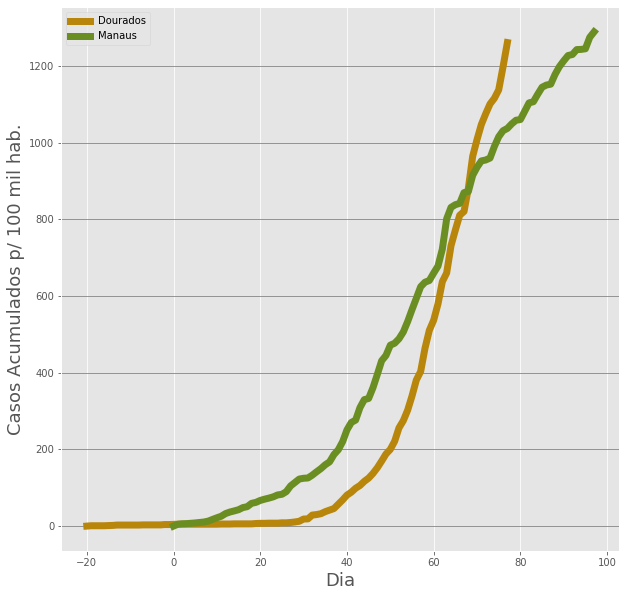

data início da reta ajustada 2020-05-25 00:00:00
data início da reta ajustada 2020-05-11 00:00:00


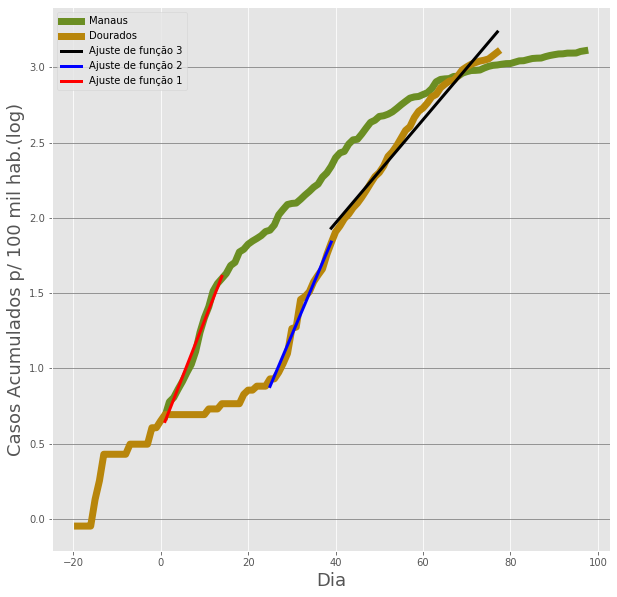


parâmetros da reta 3:  [0.03430178 0.59401207] 
 matriz de covariância:
 [[ 7.99080675e-07 -4.63466789e-05]
 [-4.63466789e-05  2.78932424e-03]]

parâmetros da reta 2:  [ 0.06850074 -0.83224762] 
 matriz de covariância:
 [[ 7.49010741e-06 -2.39683437e-04]
 [-2.39683437e-04  7.80968534e-03]]

parâmetros da reta 1:  [0.07410634 0.57384846] 
 matriz de covariância:
 [[ 7.00474659e-06 -5.25355993e-05]
 [-5.25355993e-05  5.07844127e-04]]
10**0.034301783272920376 = 1.0821856810745603


In [9]:
comp_cidades(df_cidade1, df_cidade2)

In [10]:

def editBarhPlot(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        valor = rect.get_width()
        
        if type(valor) == np.float64:
            valor = round(valor,1)
        ax.annotate('{}'.format(valor),
                    xy=( valor , rect.get_y()),
                    xytext=(3, 0),  # 3 points horisontal offset
                    textcoords="offset points",
                    ha='left', va='bottom')




def casos_est_muni(df_uf_muni, uf, pathfigs = './figs/'):
    df_uf_muni.sort_values('casosAcumulado',ascending = True, inplace=True)
    muni_leg = df_uf_muni['municipio'].unique().tolist()

    ### figura 01 - casos por município
    fig, ax = plt.subplots(figsize=(12,18))

    rec = ax.barh('municipio', 'casosAcumulado', data=df_uf_muni )
   
    ax.set_ylabel('Município',fontsize=20 )
    ax.set_xlabel('Número de Casos',fontsize=20  )
    #ax.set_title('Casos por município\n Estado do Mato Grosso do Sul', fontsize=25)
    
    #ax.legend()

    editBarhPlot(rec, ax)
    plt.savefig( pathfigs + 'casos_por_municipio' + '.png', format ='png',  bbox_inches='tight')
    plt.show()

    ### figura dois - casos por cem mil habitantes
    df_uf_muni.sort_values('CA_por_cemMil_Hab',ascending = True, inplace=True)

    fig, ax = plt.subplots(figsize=(12,18))
   
    rec = ax.barh('municipio', 'CA_por_cemMil_Hab', data=df_uf_muni, color= 'brown')
   
    ax.set_ylabel('Município',fontsize=20 )
    ax.set_xlabel('Número de Casos por 100 mil habitantes',fontsize=20  )
    #ax.set_title('Casos por 100 mil habitantes\n Estado do Mato Grosso do Sul', fontsize=25)
    
    #ax.legend()

    editBarhPlot(rec, ax)
    plt.savefig( pathfigs + 'casos_100_mil_por_municipio' + '.png', format ='png',  bbox_inches='tight')
    plt.show()

        ### figura três - população
    df_uf_muni.sort_values('populacaoTCU2019',ascending = True, inplace=True)

    fig, ax = plt.subplots(figsize=(12,18))
   
    rec = ax.barh('municipio', 'populacaoTCU2019', data=df_uf_muni, color= 'cadetblue')
   
    ax.set_ylabel('Município',fontsize=20 )
    ax.set_xlabel('População estimada (TCU 2019)',fontsize=20  )
    #ax.set_title('População por Município\n Estado do Mato Grosso do Sul', fontsize=25)
    
    #ax.legend()

    editBarhPlot(rec, ax)
    plt.savefig( pathfigs + 'pop_por_municipio' + '.png', format ='png',  bbox_inches='tight')
    plt.show()



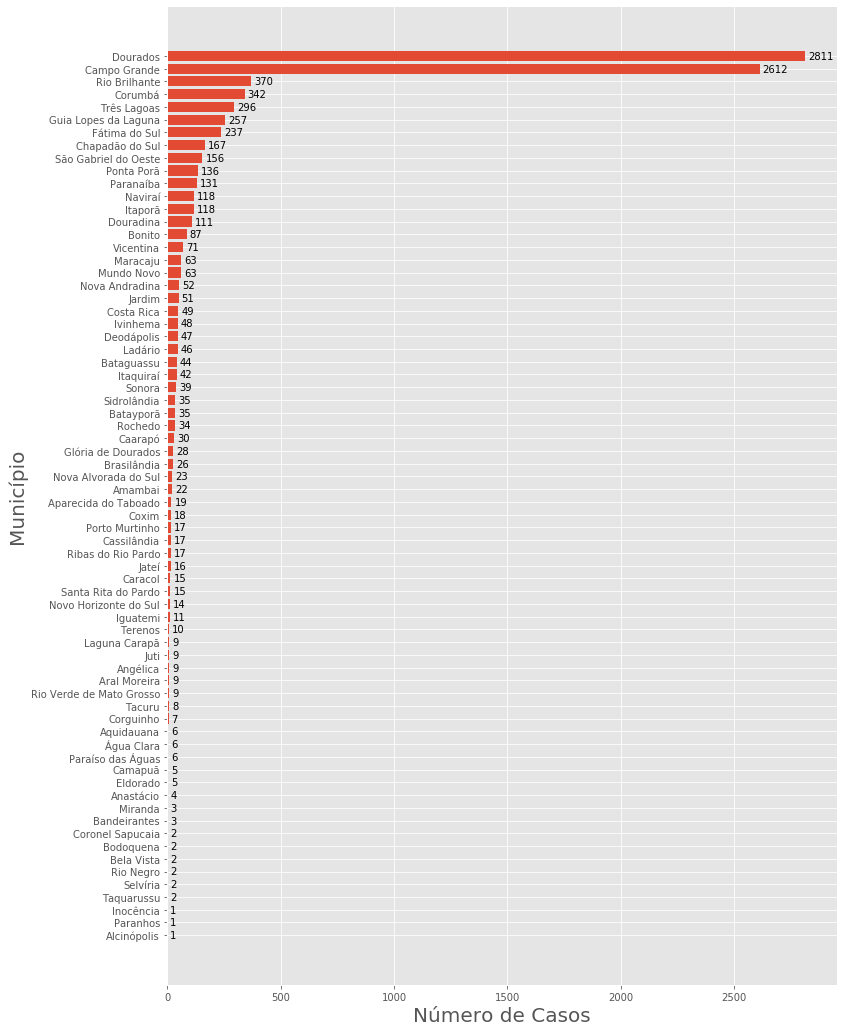

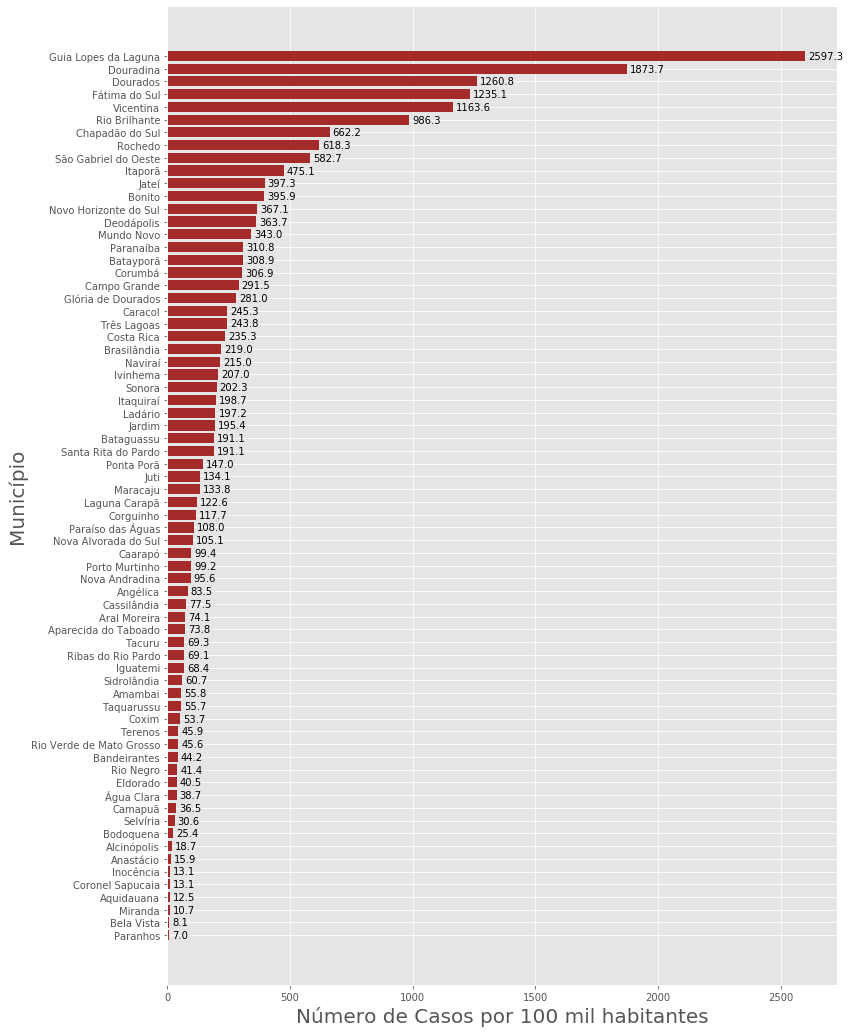

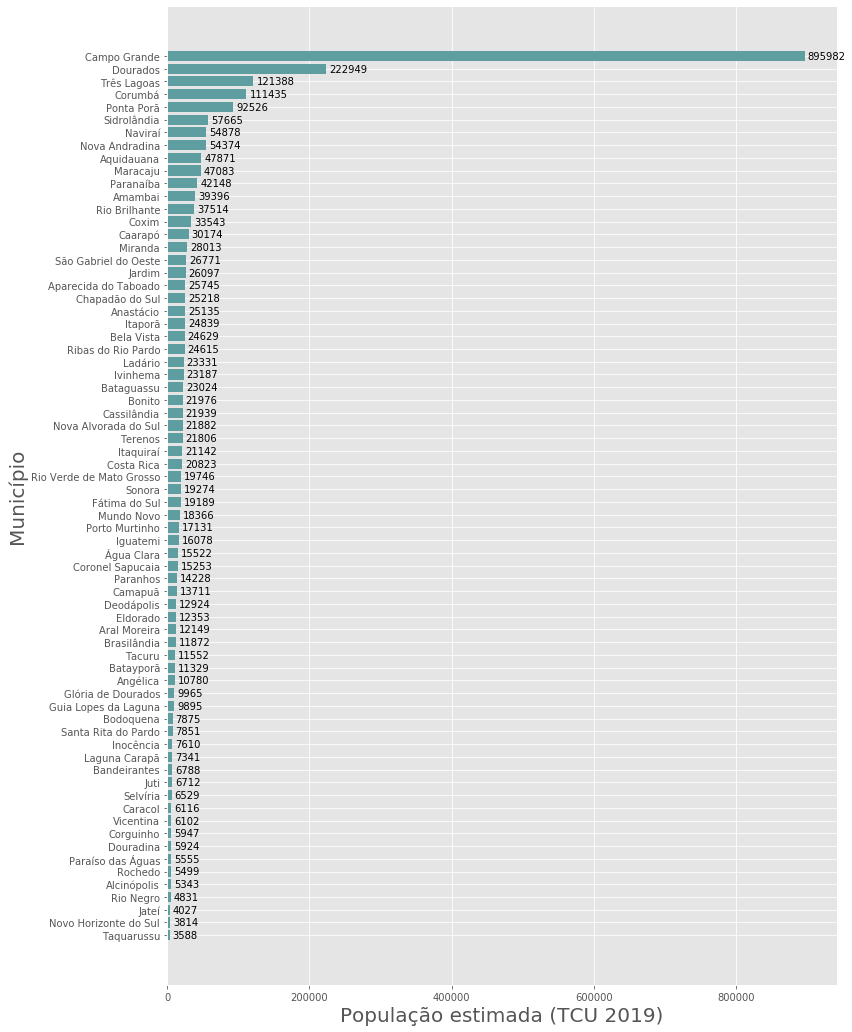

In [11]:
casos_est_muni(df_est1_muni, uf_list[0])

In [12]:
df_est1_muni

municipio  populacaoTCU2019  casosAcumulado  obitosAcumulado  \
65             Taquarussu              3588               2                0   
48  Novo Horizonte do Sul              3814              14                0   
38                  Jateí              4027              16                0   
56              Rio Negro              4831               2                0   
0             Alcinópolis              5343               1                0   
..                    ...               ...             ...              ...   
52             Ponta Porã             92526             136                4   
22                Corumbá            111435             342               10   
67            Três Lagoas            121388             296                5   
27               Dourados            222949            2811               26   
16           Campo Grande            895982            2612               13   

    CA_por_cemMil_Hab  OA_por_cemMil_Hab  CA_cemMil_log  OA_cemMil_log  
65          55.741360           0.000000       1.746178           -inf  
48         367.068694           0.000000       2.564747           -inf  
38         397.318103           0.000000       2.599138           -inf  
56          41.399296           0.000000       1.616993           -inf  
0           18.716077           0.000000       1.272215           -inf  
..                ...                ...            ...            ...  
52         146.985712           4.323109       2.167275       0.635796  
22         306.905371           8.973841       2.487004       0.952978  
67         243.846179           4.119023       2.387116       0.614794  
27        1260.826467          11.661860       3.100655       1.066768  
16         291.523714           1.450922       2.464674       0.161644  

[70 rows x 8 columns]

In [13]:
mapa = gpd.read_file('../data/geojsonDL/MS.json', driver='GeoJSON')
mapa.rename(columns={'NOME': 'municipio'}, inplace=True)


In [14]:
def mapa_estado_muni(df, df_geo, nLevels, pathfigs ='./figs/'):
    df1 = df.set_index('municipio')
    mapaPlot = df_geo.join(df1, on='municipio' , how= 'outer')
    mapaPlot.head()
    mapaPlot.dropna(inplace=True)

    mapaPlot['coords'] = mapaPlot['geometry'].apply(lambda x: x.representative_point().coords[:])
    mapaPlot['coords'] = [coords[0] for coords in mapaPlot['coords']]

    fig, ax1 = plt.subplots(1, 1, figsize=(15,15))

    geoplot.polyplot(df_geo, ax=ax1)
    casos_p_habitante = mapaPlot['CA_por_cemMil_Hab']
    scheme = mapclassify.Quantiles(casos_p_habitante, k=nLevels)

    #plt.title('Covid - Casos Diagnosticados em cada município por 100 mil habitantes', fontsize=25 )
    geoplot.choropleth(
        mapaPlot, hue= casos_p_habitante , scheme=scheme, ax=ax1,
        cmap='Oranges', legend=True, ec='k'
    )

    for idx, row in mapaPlot.iterrows():
        if row['municipio'] == 'Dourados':
            colorName = 'yellow'
            fontS = 12
        elif row['municipio'] == 'Campo Grande':
            colorName = 'darkslategray'
            fontS = 12
        else:
            colorName = 'k'
            fontS = 5

        plt.annotate(s=row['municipio'], xy=row['coords'], horizontalalignment='center', fontsize =fontS, color = colorName)
    plt.savefig( pathfigs + 'mapa_casos_100_mil' + '.png', format ='png',  bbox_inches='tight')
### figura 02 - casos caumulados
    fig, ax1 = plt.subplots(1, 1, figsize=(15,15))

    geoplot.polyplot(df_geo, ax=ax1)
    casos_tot = mapaPlot['casosAcumulado']
    scheme = mapclassify.Quantiles(casos_tot, k=nLevels)

    #plt.title('Covid - Casos Diagnosticados Totais', fontsize=25 )
    geoplot.choropleth(
        mapaPlot, hue= casos_tot , scheme=scheme, ax=ax1,
        cmap='Reds', legend=True, ec='k'
    )



    for idx, row in mapaPlot.iterrows():
        if row['municipio'] == 'Dourados':
            colorName = 'yellow'
            fontS = 12
        elif row['municipio'] == 'Campo Grande':
            colorName = 'darkslategray'
            fontS = 12
        else:
            colorName = 'k'
            fontS = 5

        plt.annotate(s=row['municipio'], xy=row['coords'], horizontalalignment='center', fontsize =fontS, color = colorName)
    plt.savefig( pathfigs + 'mapa_casos_registrados' + '.png', format ='png')

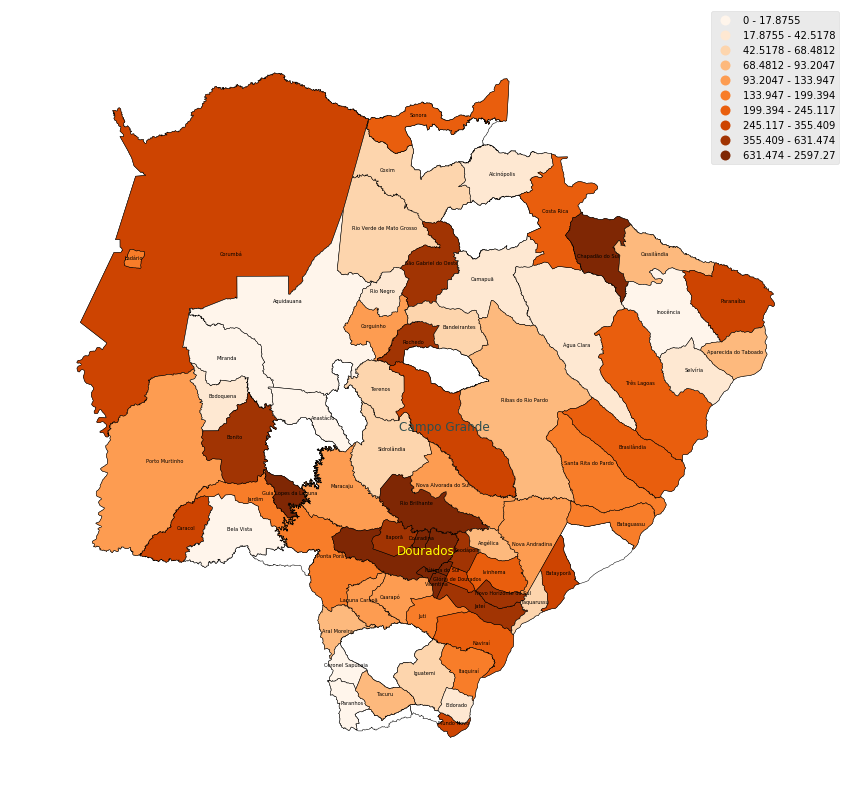

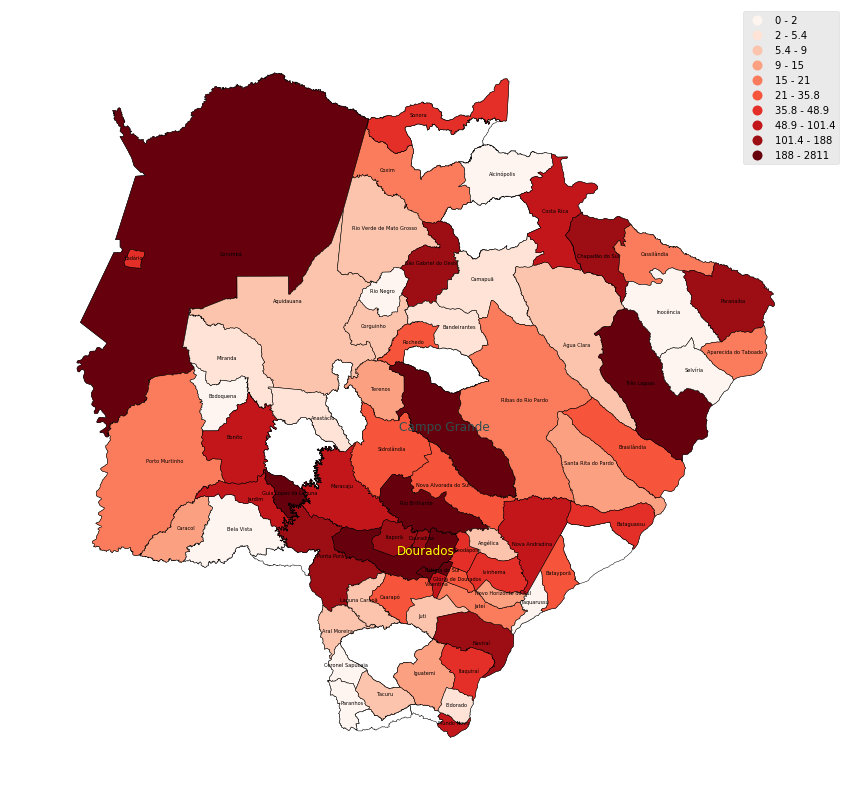

In [15]:
mapa_estado_muni(df_est1_muni, mapa, 10)

In [16]:
222949/895982

0.2488320077858707

## Casos acumulados no estado

In [17]:
casosTotMs =df_est1_muni.agg({'casosAcumulado': sum})
casosTotMs

casosAcumulado    9079
dtype: int64

### Proporção de casos de Dourados em relação ao estado

In [18]:
fltr = df_est1_muni['municipio'] == 'Dourados'
df_est1_muni.loc[fltr, :].agg({'casosAcumulado': sum})/casosTotMs

casosAcumulado    0.309616
dtype: float64

### Proporção de casos de Dourados em relação à Campo Grande

In [19]:
fltr = df_est1_muni['municipio'].isin(['Dourados', 'Campo Grande'])
doucampG = df_est1_muni.loc[fltr, :]
print('\n',doucampG.head())
print('\nProporção de casos Dourados/ Campo Grande')
print(doucampG.iloc[0,2]/doucampG.iloc[1,2])


        municipio  populacaoTCU2019  casosAcumulado  obitosAcumulado  \
27      Dourados            222949            2811               26   
16  Campo Grande            895982            2612               13   

    CA_por_cemMil_Hab  OA_por_cemMil_Hab  CA_cemMil_log  OA_cemMil_log  
27        1260.826467          11.661860       3.100655       1.066768  
16         291.523714           1.450922       2.464674       0.161644  

Proporção de casos Dourados/ Campo Grande
1.076186830015314


### Casos Acumulados no entrono imediado de Dourados

In [20]:
divisas = ['Maracaju', 'Rio Brilhante', 'Itaporã', 'Douradina', 'Deodápolis', 'Fátima do Sul', 'Caarapó', 'Laguna Carapã', 'Ponta Porã']
fltr = df_est1_muni['municipio'].isin(divisas + ['Dourados'])
df_divisas = df_est1_muni.loc[fltr, :]
print(df_divisas.shape)
entornoDoucasos = df_divisas.agg({'casosAcumulado': sum})
entornoDoucasos

(10, 8)


casosAcumulado    3932
dtype: int64

In [21]:
entornoDoucasos/casosTotMs

casosAcumulado    0.433087
dtype: float64

### Considerando Vicentina e Glória de Dourados

In [22]:
prox2 = ['Vicentina', 'Glória de Dourados']
fltr = df_est1_muni['municipio'].isin(divisas + ['Dourados'] + prox2)
entornoExp = df_est1_muni.loc[fltr, :].agg({'casosAcumulado': sum})
entornoExp

casosAcumulado    4031
dtype: int64

In [23]:
entornoExp/casosTotMs

casosAcumulado    0.443992
dtype: float64